## Imports

https://www.kaggle.com/mlg-ulb/creditcardfraud

In [98]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, confusion_matrix, f1_score, accuracy_score, average_precision_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import plot_precision_recall_curve
import keras
import tensorflow_addons as tfa
import keras.backend as K
from tqdm import tqdm
plt.style.use("seaborn")

In [99]:
records = pd.read_csv('creditcard.csv', delimiter=',', header=0)

# Check if data is well-formed

## Distribution of fraudulent vs. good transactions
Very few fraudulent records

In [100]:
records.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

## Normalize data

In [101]:
#Mean normalization
targets = records.pop('Class')
normalized_records=(records-records.mean())/records.std()
#normalized_records.hist(figsize=(20,20));

## Compare hists between classes

In [102]:
records0 = normalized_records[targets==0]
records1 = normalized_records[targets==1]
#records0.hist(figsize=(20,20));

In [103]:
#records1.hist(figsize=(20,20));

In [104]:
print("Differences between fraud and non-fraud:")
for i in records0.keys():
    print("Differences in",i)
    print("Median:", records0[i].median()-records1[i].median())
    print("Mean:", records0[i].mean()-records1[i].mean())
    print("Std:", records0[i].std()-records1[i].std())
    
    print()

Differences between fraud and non-fraud:
Differences in Time
Median: 0.19252172971223316
Mean: 0.2967350075315986
Std: -0.007398674870575661

Differences in V1
Median: 1.2061703137691455
Mean: 2.4405046304538205
Std: -2.4781146185470924

Differences in V2
Median: -1.6070883853499391
Mean: -2.198286258857717
Std: -1.6078579173914733

Differences in V3
Median: 3.4673686501116703
Mean: 4.64661415234859
Std: -3.727280862082994

Differences in V4
Median: -2.966060774701858
Mean: -3.2134966851943867
Std: -1.041046096449672

Differences in V5
Median: 1.0646680521499936
Mean: 2.2870389213706708
Std: -2.9092742802983906

Differences in V6
Median: 0.8643081611514458
Mean: 1.050953871019782
Std: -0.3964738063666099

Differences in V7
Median: 2.4861012371395548
Mean: 4.509252688613915
Std: -4.872679520684369

Differences in V8
Median: -0.5019178436083024
Mean: -0.4786050799310731
Std: -4.719331507786939

Differences in V9
Median: 1.9649929610563892
Mean: 2.3534625610834463
Std: -1.2848010599682733

In [105]:
top10 = ['V3', 'V4', 'V7', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18'] #Based on largest difference in median.
X = normalized_records[top10].to_numpy()
y = targets.to_numpy()

### Performance Metrics
The function below calculates a series of performance metrics.
1. Accuracy - This is the default metric and is not suited for this problem.
2. False negatives, False positives, True positives - Gives insight in how it classifies.
3. F1 score - Is considered suited for imbalanced datasets.
4. AUPRC - Area Under Precision-Recall Curve is the suggested metric from Kaggle.
5. AUC ROC - Area Under Curve Receiving Operating Characteristic is widely used for this specific task, but not good for imbalanced datasets
6. Average Precision - Should be a good overall measure for this task. 
7. Mean score for metrics - The mean for 3, 4, 5, 6

In [191]:
#True negatives are not printed due to it being the default classification.
def evaluate_model(model, name="", verbose=False):
    preds = model.predict(X_test)
    preds_proba = model.predict_proba(X_test)[:,1]
    precision, recall, _ = precision_recall_curve(y_test, preds_proba)
    fpr, tpr, _ = roc_curve(y_test, preds_proba)
    f1 = f1_score(preds, y_test)
    aucroc = auc(fpr, tpr)
    auprc = auc(recall, precision)
    avg_precision = average_precision_score(y_test, preds_proba)
    mean_score = np.mean([f1, auprc, aucroc, avg_precision])
    
    if verbose:
        cm = confusion_matrix(preds, y_test)
        tn, fp, fn, tp = cm.ravel()
        
        print("{} performance metrics:\n-=-=-=-=-=-".format(name))
        print("Raw accuracy (bad metric):", accuracy_score(preds, y_test))
        print("False negatives:", fn)
        print("False positives:", fp)
        print("True positives:", tp)
        print("F1 score:", f1)

        print("AUPRC:", auprc)
        print("AUC ROC:", aucroc)
        print("Average Precision Score:", avg_precision)
        print("Mean Score for Metrics:", mean_score)
        print()
    
    return [f1, auprc, aucroc, avg_precision, mean_score]

def print_scores(scores, name=""):
    print("{} performance metrics:\n-=-=-=-=-=-".format(name))
    print("F1 score:", scores[0])
    print("AUPRC:", scores[1])
    print("AUC ROC:", scores[2])
    print("Average Precision Score:", scores[3])
    print("Mean Score for Metrics:", scores[4])
    print()

def AUC_PR(preds_proba):
    precision, recall, _ = precision_recall_curve(y_test, preds_proba)
    auprc = auc(recall, precision)

## Evaluation
Using Stratified K-fold and the metrics above

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

skf = StratifiedKFold(n_splits=5, random_state=42)
lrg = LogisticRegression(n_jobs=4, random_state=42)
knn = KNeighborsClassifier(n_jobs=4)
rfc = RandomForestClassifier(n_estimators=300, n_jobs=4, random_state=42)
nb = GaussianNB()
mlp = MLPClassifier(hidden_layer_sizes=[1000,200], random_state=42) #1000 500
dum = DummyClassifier(random_state=42)


def cross_val_train_model(model, name=""):
    
    accuracies = []
    for train_index, valid_index in tqdm(skf.split(X_train,y_train)):
        X_strat_train, X_valid = X[train_index], X[valid_index]
        y_strat_train, y_valid = y[train_index], y[valid_index]

        model.fit(X_strat_train, y_strat_train)
        accuracies.append(evaluate_model(model))

    print_scores(np.mean(accuracies, axis=0), name=name)

c:\python37\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [110]:
cross_val_train_model(dum, name="Baseline")
cross_val_train_model(lrg, name="Logistic Regression")
cross_val_train_model(knn, name="K-Nearest neighbours")
cross_val_train_model(rfc, name="Random Forest")
cross_val_train_model(nb, name="Naive Bayes")
cross_val_train_model(mlp, name="Multilayer Perceptron")
# cross_val_train_model(nn, name="Neural Network")

0it [00:00, ?it/s]c:\python37\lib\site-packages\sklearn\dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
5it [00:00, 13.20it/s]
0it [00:00, ?it/s]

Baseline performance metrics:
-=-=-=-=-=-
F1 score: 0.0
AUPRC: 0.000779472486727901
AUC ROC: 0.49909974539674506
Average Precision Score: 0.001558944973455802
Mean Score for Metrics: 0.1253595407142322



5it [00:11,  2.40s/it]
0it [00:00, ?it/s]

Logistic Regression performance metrics:
-=-=-=-=-=-
F1 score: 0.6523944971718915
AUPRC: 0.6637284445042675
AUC ROC: 0.9567238335943233
Average Precision Score: 0.665032313766839
Mean Score for Metrics: 0.7344697722593304



5it [01:14, 14.83s/it]
0it [00:00, ?it/s]

K-Nearest neighbours performance metrics:
-=-=-=-=-=-
F1 score: 0.8469492593220391
AUPRC: 0.896691881008364
AUC ROC: 0.9602342436118863
Average Precision Score: 0.8446645759128419
Mean Score for Metrics: 0.8871349899637828



5it [05:28, 65.65s/it]
1it [00:00,  6.68it/s]

Random Forest performance metrics:
-=-=-=-=-=-
F1 score: 0.9336265810525042
AUPRC: 0.9060311613157005
AUC ROC: 0.972934093734195
Average Precision Score: 0.9006095203861951
Mean Score for Metrics: 0.9283003391221486



5it [00:00,  7.21it/s]
0it [00:00, ?it/s]

Naive Bayes performance metrics:
-=-=-=-=-=-
F1 score: 0.2245732452135197
AUPRC: 0.47477042641584466
AUC ROC: 0.9522272240591014
Average Precision Score: 0.23279554759106214
Mean Score for Metrics: 0.471091610819882



5it [1:14:03, 888.72s/it]

Multilayer Perceptron performance metrics:
-=-=-=-=-=-
F1 score: 0.8142269253925667
AUPRC: 0.8141910670393063
AUC ROC: 0.9755368230618263
Average Precision Score: 0.8147388586168207
Mean Score for Metrics: 0.85467341852763



In [ ]:
# evaluate_model(dum, name='Dummy Classifier', verbose=True)
# evaluate_model(lrg, name="Logistic Regression", verbose=True)
# evaluate_model(knn, name='K-Nearest Neighbours', verbose=True)
# evaluate_model(rfc, name="Random Forest", verbose=True)
# evaluate_model(nb, name="Naive Bayes", verbose=True)
# evaluate_model(mlp, name="Multilayer Perceptron", verbose=True)

In [111]:
def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], label='Train')
        #plt.plot(history.epoch, history.history['val_'+metric],color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()

Epoch 1/8
3205/3205 [==============================] - 5s 1ms/step - loss: 0.1420 - prc: 0.1433 - val_loss: 0.0129 - val_prc: 0.6280
Epoch 2/8
3205/3205 [==============================] - 5s 2ms/step - loss: 0.0086 - prc: 0.6355 - val_loss: 0.0056 - val_prc: 0.6731
Epoch 3/8
3205/3205 [==============================] - 5s 1ms/step - loss: 0.0049 - prc: 0.6822 - val_loss: 0.0048 - val_prc: 0.6795
Epoch 4/8
3205/3205 [==============================] - 5s 1ms/step - loss: 0.0043 - prc: 0.7135 - val_loss: 0.0045 - val_prc: 0.7051
Epoch 5/8
3205/3205 [==============================] - 5s 1ms/step - loss: 0.0041 - prc: 0.7228 - val_loss: 0.0043 - val_prc: 0.7167
Epoch 6/8
3205/3205 [==============================] - 5s 1ms/step - loss: 0.0039 - prc: 0.7227 - val_loss: 0.0042 - val_prc: 0.7276
Epoch 7/8
3205/3205 [==============================] - 5s 2ms/step - loss: 0.0035 - prc: 0.7549 - val_loss: 0.0041 - val_prc: 0.7352
Epoch 8/8
3205/3205 [==============================] - 5s 1ms/step - 

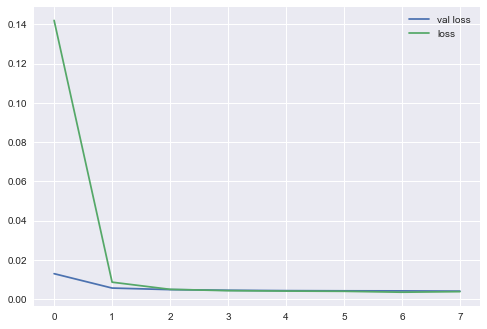

In [186]:
focal_loss = tfa.losses.SigmoidFocalCrossEntropy(alpha=1, gamma=10)
epochs_ = 8
batch_size_ = 25

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.5)

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

nn = keras.Sequential([
    keras.layers.Dense(200, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation="sigmoid"),
])


#Validation data

nn.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), #'binary_crossentropy'
           loss='binary_crossentropy', # Cite this https://towardsdatascience.com/a-loss-function-suitable-for-class-imbalanced-data-focal-loss-af1702d75d75
           metrics=[keras.metrics.AUC(name='prc', curve='PR')])
history = nn.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=epochs_, batch_size=batch_size_)
#nn.evaluate(X_test, y_test)
plt.plot(history.history['val_loss'], label="val loss")
plt.plot(history.history['loss'], label="loss")
plt.legend()

In [188]:
nn.evaluate(X_test)

2226/2226 [==============================] - 1s 610us/step - loss: 0.0000e+00 - prc: 0.0000e+00


[0.0, 0.0]

Text(0.5, 1.0, 'Focal loss, ')

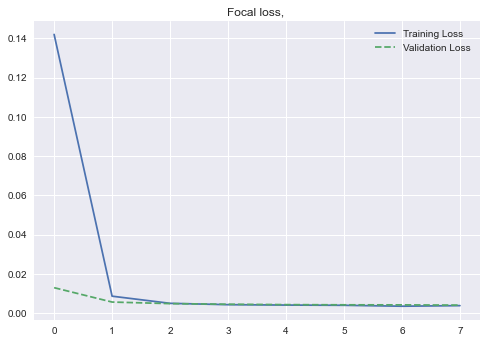

In [189]:
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], '--', label="Validation Loss")
plt.legend()
plt.title("Focal loss, ")

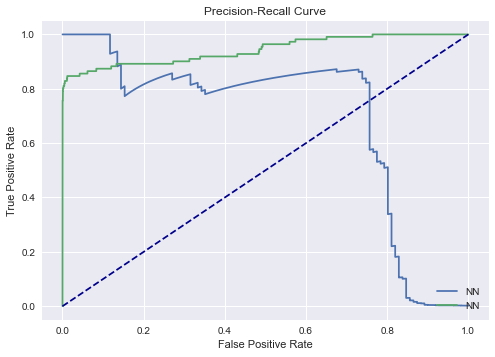

In [190]:
create_pr_curve(nn.predict(X_test), y_test, label="NN", title="Precision-Recall Curve")
create_roc_curve(nn.predict(X_test), y_test, label="NN", title="Precision-Recall Curve")
AUC_PR()

In [172]:
nn.predict(X_test)

array([[1.4218688e-04],
       [1.2143117e-06],
       [2.0139258e-05],
       ...,
       [2.2586777e-05],
       [3.7044287e-04],
       [2.6144360e-05]], dtype=float32)

In [156]:
history.history['prc']

[0.5168852210044861,
 0.5410658717155457,
 0.5346726179122925,
 0.4704974889755249,
 0.4345034062862396,
 0.4164983332157135]

In [157]:
nn.evaluate(X_test)

2226/2226 [==============================] - 1s 640us/step - loss: 0.0000e+00 - prc: 0.0000e+00


[0.0, 0.0]

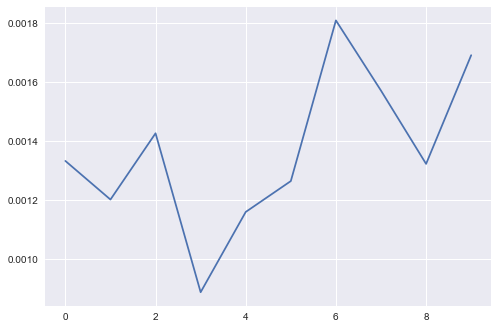

In [149]:
plt.plot(history.history['val_loss'], label="val loss")

In [122]:
mlp.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': [1000, 200],
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 42,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [119]:
evaluate_model(lrg, verbose=True)

 performance metrics:
-=-=-=-=-=-
Raw accuracy (bad metric): 0.9989887924496503
False negatives: 21
False positives: 51
True positives: 60
F1 score: 0.625
AUPRC: 0.660891641643524
AUC ROC: 0.9598326013062055
Average Precision Score: 0.6622137705085297
Mean Score for Metrics: 0.7269845033645649



[0.625,
 0.660891641643524,
 0.9598326013062055,
 0.6622137705085297,
 0.7269845033645649]

In [113]:
def plot_roc_cur(fper, tper, label="", title="plot title"):
    plt.plot(fper, tper, label=label)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    
def create_roc_curve(preds, targets, label="", title=""):
    all_fpr, all_tpr = [], []
    fpr, tpr, thresholds = roc_curve(targets, preds)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_fpr = np.array(all_fpr)
    all_tpr = np.array(tpr)
    
    plot_roc_cur(all_fpr[0], all_tpr, label=label, title=title)

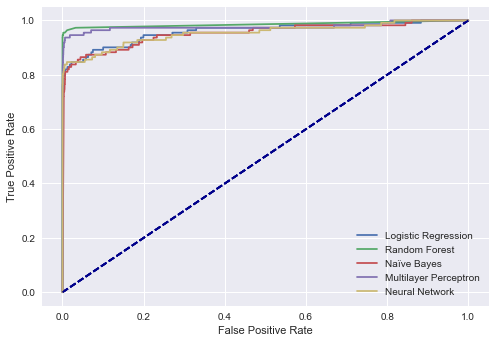

In [175]:
create_roc_curve(lrg.predict_proba(X_test)[:,1], y_test, label="Logistic Regression")
#create_roc_curve(svc.predict_proba(X_test)[:,1], y_test, label="Support Vector Classifier")
create_roc_curve(rfc.predict_proba(X_test)[:,1], y_test, label="Random Forest")
create_roc_curve(nb.predict_proba(X_test)[:,1], y_test, label="Naïve Bayes")
create_roc_curve(mlp.predict_proba(X_test)[:,1], y_test, label="Multilayer Perceptron")
create_roc_curve(nn.predict(X_test), y_test, label="Neural Network")

## Precicion Recall Curve

In [176]:
def plot_pr_cur(p, r, label="", title="plot title"):
    plt.plot(r, p, label=label)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc='best')
    
def create_pr_curve(preds, targets, label="", title=""):
    all_p, all_r = [], []
    p, r, thresholds = precision_recall_curve(targets, preds)
    all_p.append(p)
    all_r.append(r)
    all_p = np.array(p)
    all_r = np.array(r)
    
    plot_pr_cur(all_p, all_r, label=label, title=title)

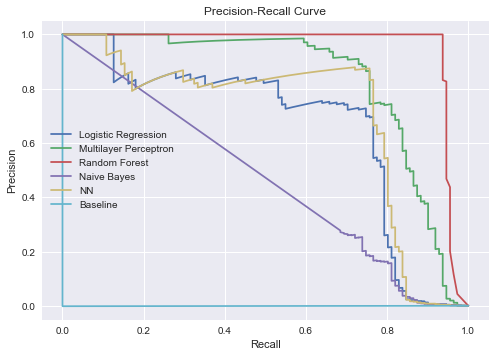

In [177]:
create_pr_curve(lrg.predict_proba(X_test)[:,1], y_test, label="Logistic Regression")
create_pr_curve(mlp.predict_proba(X_test)[:,1], y_test, label="Multilayer Perceptron")
create_pr_curve(rfc.predict_proba(X_test)[:,1], y_test, label="Random Forest")
create_pr_curve(nb.predict_proba(X_test)[:,1], y_test, label="Naive Bayes")
create_pr_curve(nn.predict(X_test), y_test, label="NN")
create_pr_curve(dum.predict_proba(X_test)[:,1], y_test, label="Baseline", title="Precision-Recall Curve")

In [ ]:
keras.backend.sum